In [9]:
import os
import matplotlib.pyplot as plt
from typing import List, Dict


from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import CharErrorRate

from dataset import OCRDataset
from model import OCREncoder, OCRDecoder, OCRModel

# Load data

In [2]:
transform = transforms.Compose([
    transforms.Resize((48, 80)),
    transforms.ToTensor(),
])

In [3]:
data = OCRDataset("data/samples", transform=transform)

train_data, test_data = torch.utils.data.random_split(data, 
                                                  [int(0.8 * len(data)), int(0.2 * len(data))], 
                                                  generator=torch.Generator().manual_seed(42)
                                                 )

# Load model

In [4]:
encoder = OCREncoder()
decoder = OCRDecoder(output_dim=len(data.vocab))
net = OCRModel(encoder, decoder)

cer_metric = CharErrorRate()

In [5]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

# Get errors

In [6]:
net.eval()
net = net.to('cuda')

errors = []

for k, (img, target) in enumerate(tqdm(test_data)):
    img = img.to('cuda')
    output = net(img.unsqueeze(0)).squeeze(0)
    p = output.argmax(dim=-1).tolist()
    t = target.tolist()
    cer = cer_metric([p], [t]).item()
    if cer > 0:
        errors.append((k, cer))

100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 37.70it/s]


In [11]:
errors

[(1, 0.20000000298023224),
 (3, 0.20000000298023224),
 (5, 0.20000000298023224),
 (8, 0.20000000298023224),
 (10, 0.20000000298023224),
 (12, 0.20000000298023224),
 (16, 0.4000000059604645),
 (23, 0.20000000298023224),
 (24, 0.20000000298023224),
 (28, 0.20000000298023224),
 (29, 0.20000000298023224),
 (33, 0.20000000298023224),
 (43, 0.4000000059604645),
 (47, 0.4000000059604645),
 (53, 0.20000000298023224),
 (56, 0.20000000298023224),
 (59, 0.20000000298023224),
 (65, 0.4000000059604645),
 (67, 0.4000000059604645),
 (68, 0.4000000059604645),
 (72, 0.4000000059604645),
 (73, 0.20000000298023224),
 (75, 0.20000000298023224),
 (80, 0.20000000298023224),
 (81, 0.20000000298023224),
 (86, 0.20000000298023224),
 (89, 0.4000000059604645),
 (90, 0.4000000059604645),
 (95, 0.20000000298023224),
 (105, 0.20000000298023224),
 (110, 0.20000000298023224),
 (111, 0.20000000298023224),
 (113, 0.20000000298023224),
 (123, 0.20000000298023224),
 (124, 0.20000000298023224),
 (134, 0.20000000298023224)

# Visualisation

In [37]:
def get_pred(number):
    img, target = test_data[number]
    img = img.to('cuda')
    output = net(img.unsqueeze(0)).squeeze(0)
    p = output.argmax(dim=-1).tolist()
    plt.imshow(img.cpu().squeeze(0))
    plt.show()
    print('Target', data.decode(target.tolist()))
    print('Pred', data.decode(p))

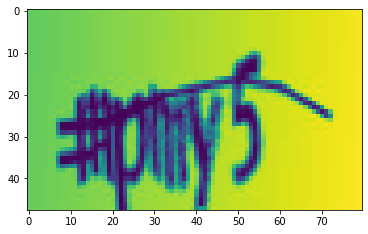

Target mpmy5
Pred mnmy5


In [38]:
get_pred(1)

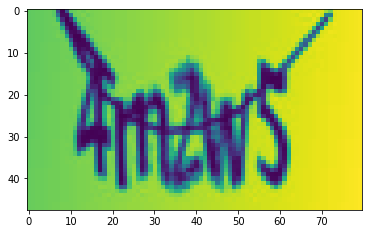

Target 4m2w5
Pred 8m3w5


In [39]:
get_pred(90)

# Выводы

1. Ошибки возникают из-за недостаточного кол-ва обучающих примеров. 
Возможность исправления: 
 - аугментации
 - генерация сентетики
 - обогащение выборки
 
2. Модель сильно переобучается на трейновых примерах (лосс практичеки 0). Нужно давать более жесткие аугментации.